# Prompt:

## How does geography correlate with other data attributes, such as provider density, provider specialties, or costs?

Before getting deep into the dataset, good to note:

1. All of this data covers beneficiaries with Medicare beneficiaries with a Part D prescription drug plan. So this will **not represent prescriber's entire prescribing program pattern**.
2. **70% of Medicare** beneficiaries are represented in this dataset only.
3. For providers that have more than one Medicare speciality code reported on their claims, Medicare specialty code assocaited with largest number of services is reported. 
4. This does **not indicate the quality of care that is provided**.
5. Due to Medicare Part D only representing portion of population, **any statistics done on drugs (costs) will not be representative of whole population**.
6. Due to Medicare D only covering a portion of drug process, this dataset will **not fully represent total drug costs** at the prescriber or drug level to payments from the Medicare Trust Fund.
7. Also, good to take note that there can be **transcription error** when tying prescription to prescriber. 

These are to be considered prior to inferring/drawing conclusions from data analysis.

In [1]:
import matplotlib.pyplot as plt
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs,init_notebook_mode,plot,iplot
init_notebook_mode(connected=True)
import seaborn as sns 
import numpy as np
import pandas as pd
import random as rnd
from sklearn.metrics import confusion_matrix
import matplotlib.gridspec as gridspec
from sklearn.preprocessing import StandardScaler
from numpy import genfromtxt
from scipy import stats
from scipy.stats import multivariate_normal
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score , average_precision_score
from sklearn.metrics import precision_score, precision_recall_curve
%matplotlib inline

# EDA of 2017 Dataset

In [2]:
Prescriber_2017 = pd.read_csv("Medicare_Provider_Utilization_and_Payment_Data__2017_Part_D_Prescriber.csv")
Prescriber_2017.head()

,npi,nppes_provider_last_org_name,nppes_provider_first_name,nppes_provider_city,nppes_provider_state,specialty_description,description_flag,drug_name,generic_name,bene_count,...,total_30_day_fill_count,total_day_supply,total_drug_cost,bene_count_ge65,bene_count_ge65_suppress_flag,total_claim_count_ge65,ge65_suppress_flag,total_30_day_fill_count_ge65,total_day_supply_ge65,total_drug_cost_ge65
0,1710273057,WITTICH,LILY,SPOKANE,WA,Family Practice,S,ESTRADIOL,ESTRADIOL,NaN,...,64.0,1913,448.52,NaN,#,NaN,#,NaN,NaN,NaN
1,1932112752,POLK,ELAINE,GALLUP,NM,Physician Assistant,S,LISINOPRIL,LISINOPRIL,38.0,...,180.0,5400,435.11,NaN,#,NaN,#,NaN,NaN,NaN
2,1255390571,PAJOUH,MEHDI,WESTFIELD,MA,Cardiology,S,DIGITEK,DIGOXIN,NaN,...,66.0,1980,1699.66,NaN,*,46.0,NaN,66.0,1980.0,1699.66
3,1760690028,YAACOUB,CHADI,ELGIN,IL,Interventional Pain Management,S,GABAPENTIN,GABAPENTIN,85.0,...,287.1,8536,4726.06,63.0,NaN,199.0,NaN,222.1,6611.0,3772.50
4,1336417005,RAMER,AMY,KALISPELL,MT,Nurse Practitioner,S,TRAMADOL HCL,TRAMADOL HCL,12.0,...,49.5,1277,258.68,NaN,*,26.0,NaN,30.5,854.0,177.25


In [3]:
Prescriber_2017.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25209130 entries, 0 to 25209129
Data columns (total 21 columns):
npi                              int64
nppes_provider_last_org_name     object
nppes_provider_first_name        object
nppes_provider_city              object
nppes_provider_state             object
specialty_description            object
description_flag                 object
drug_name                        object
generic_name                     object
bene_count                       float64
total_claim_count                int64
total_30_day_fill_count          float64
total_day_supply                 int64
total_drug_cost                  float64
bene_count_ge65                  float64
bene_count_ge65_suppress_flag    object
total_claim_count_ge65           float64
ge65_suppress_flag               object
total_30_day_fill_count_ge65     float64
total_day_supply_ge65            float64
total_drug_cost_ge65             float64
dtypes: float64(8), int64(3), object(10)

In [4]:
Prescriber_2017.describe()

,npi,bene_count,total_claim_count,total_30_day_fill_count,total_day_supply,total_drug_cost,bene_count_ge65,total_claim_count_ge65,total_30_day_fill_count_ge65,total_day_supply_ge65,total_drug_cost_ge65
count,2.520913e+07,1.009152e+07,2.520913e+07,2.520913e+07,2.520913e+07,2.520913e+07,3.486343e+06,1.431766e+07,1.431766e+07,1.431766e+07,1.431766e+07
mean,1.499576e+09,2.921692e+01,5.142193e+01,8.027997e+01,2.251155e+03,4.606025e+03,2.181389e+01,4.905560e+01,7.976575e+01,2.267930e+03,3.914431e+03
std,2.877824e+08,3.369993e+01,8.961933e+01,1.459194e+02,4.263119e+03,2.917278e+04,4.239447e+01,9.107605e+01,1.538780e+02,4.472969e+03,2.350166e+04
min,1.003000e+09,1.100000e+01,1.100000e+01,1.100000e+01,1.100000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.245599e+09,1.400000e+01,1.500000e+01,1.940000e+01,4.500000e+02,2.439000e+02,0.000000e+00,1.300000e+01,1.680000e+01,4.000000e+02,2.013300e+02
50%,1.497914e+09,2.000000e+01,2.400000e+01,3.590000e+01,9.600000e+02,6.432600e+02,1.400000e+01,2.200000e+01,3.300000e+01,9.230000e+02,5.836300e+02
75%,1.740694e+09,3.300000e+01,5.100000e+01,7.700000e+01,2.156000e+03,2.175990e+03,2.500000e+01,4.700000e+01,7.400000e+01,2.095000e+03,1.989340e+03
max,1.993000e+09,2.189300e+04,2.191300e+04,2.318900e+04,3.750090e+05,1.388153e+07,1.973000e+04,1.974600e+04,2.084000e+04,3.718170e+05,8.166394e+06


In [5]:
Prescriber_2017.isnull().sum()

npi                                     0
nppes_provider_last_org_name          471
nppes_provider_first_name             351
nppes_provider_city                     0
nppes_provider_state                    0
specialty_description                   0
description_flag                        0
drug_name                               0
generic_name                            0
bene_count                       15117605
total_claim_count                       0
total_30_day_fill_count                 0
total_day_supply                        0
total_drug_cost                         0
bene_count_ge65                  21722787
bene_count_ge65_suppress_flag     3486343
total_claim_count_ge65           10891465
ge65_suppress_flag               14317665
total_30_day_fill_count_ge65     10891465
total_day_supply_ge65            10891465
total_drug_cost_ge65             10891465
dtype: int64

This is a huge dataset with >25,000 rows of data consisting of provider demographics, types of drugs they prescribe, drug costs, drug refills along with how these are valued differently with those age 65 and older. 

Regarding missing data/data integrity, most missing values are in bene_count_ge65, bene_count and ge65_suppress_flag. These will not be the main columns of interest, but good to note. 

Other huge gaps in the data come from: total_claim_count_ge65, total_30_day_fill_count_ge65, total_day_supply_ge65 and total_drug_cost_ge65. This is expected since only a portion of providers' care will be the elderly.

**Due to most missing data coming from columns that are not going to be analyzed, no rows are eliminated at this point.**

Some columns briefly looked at that which are relevant to prompt:

In [6]:
Prescriber_2017['nppes_provider_state'].value_counts(ascending=False).nlargest(10)

CA    2394317
NY    1715994
FL    1686023
TX    1575213
PA    1271317
OH    1047087
IL     901698
NC     899910
MI     882556
GA     715593
Name: nppes_provider_state, dtype: int64

Most providers listed are from CA, NY, FL and TX, which are the most dense states in all of US. Also, FL is the biggest retirement community. So these listed in the top 10 makes sense.

In [7]:
Prescriber_2017['specialty_description'].value_counts(ascending=False).nlargest(10)

Family Practice        7087620
Internal Medicine      6563601
Nurse Practitioner     3133372
Physician Assistant    1430495
Cardiology              834793
Psychiatry              659407
General Practice        481873
Neurology               405232
Emergency Medicine      298943
Nephrology              294921
Name: specialty_description, dtype: int64

The top two specialties listed are Family Practice and Internal Med.

## Visualizations

Let's look at counts and spread of variables.

In [8]:
prescriber_count = Prescriber_2017.groupby(['npi']).count()

In [9]:
prescriber_count.sort_values(['nppes_provider_last_org_name'],ascending = False).head(10)

,nppes_provider_last_org_name,nppes_provider_first_name,nppes_provider_city,nppes_provider_state,specialty_description,description_flag,drug_name,generic_name,bene_count,total_claim_count,total_30_day_fill_count,total_day_supply,total_drug_cost,bene_count_ge65,bene_count_ge65_suppress_flag,total_claim_count_ge65,ge65_suppress_flag,total_30_day_fill_count_ge65,total_day_supply_ge65,total_drug_cost_ge65
npi,,,,,,,,,,,,,,,,,,,,
1285761833,572,572,572,572,572,572,572,572,369,572,572,572,572,183,389,419,153,419,419,419
1598788689,527,527,527,527,527,527,527,527,324,527,527,527,527,146,381,385,142,385,385,385
1588658348,515,515,515,515,515,515,515,515,299,515,515,515,515,165,350,359,156,359,359,359
1750432969,492,492,492,492,492,492,492,492,298,492,492,492,492,127,365,337,155,337,337,337
1285618579,480,480,480,480,480,480,480,480,288,480,480,480,480,128,352,328,152,328,328,328
1619952520,478,478,478,478,478,478,478,478,283,478,478,478,478,189,289,374,104,374,374,374
1083619670,472,472,472,472,472,472,472,472,243,472,472,472,472,96,376,367,105,367,367,367
1538145925,451,451,451,451,451,451,451,451,240,451,451,451,451,121,330,324,127,324,324,324
1780637868,444,444,444,444,444,444,444,444,236,444,444,444,444,86,358,332,112,332,332,332


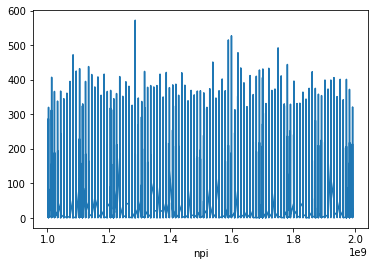

In [10]:
prescriber_count['nppes_provider_last_org_name'].plot.line()

We can see here that one prescriber had an exceptional amount of prescriptions (572) whereas most prescribers were averaging in the 400's.

In [11]:
city_count = Prescriber_2017.groupby(['nppes_provider_city']).count()

In [12]:
city_count.sort_values(['nppes_provider_last_org_name'],ascending = False)

,npi,nppes_provider_last_org_name,nppes_provider_first_name,nppes_provider_state,specialty_description,description_flag,drug_name,generic_name,bene_count,total_claim_count,total_30_day_fill_count,total_day_supply,total_drug_cost,bene_count_ge65,bene_count_ge65_suppress_flag,total_claim_count_ge65,ge65_suppress_flag,total_30_day_fill_count_ge65,total_day_supply_ge65,total_drug_cost_ge65
nppes_provider_city,,,,,,,,,,,,,,,,,,,,
NEW YORK,230595,230595,230595,230595,230595,230595,230595,230595,74839,230595,230595,230595,230595,33504,197091,145820,84775,145820,145820,145820
BROOKLYN,194515,194511,194515,194515,194515,194515,194515,194515,72782,194515,194515,194515,194515,24999,169516,120287,74228,120287,120287,120287
HOUSTON,180358,180358,180358,180358,180358,180358,180358,180358,79654,180358,180358,180358,180358,26824,153534,97219,83139,97219,97219,97219
CHICAGO,169409,169409,169409,169409,169409,169409,169409,169409,59512,169409,169409,169409,169409,22477,146932,93701,75708,93701,93701,93701
LOS ANGELES,159215,159215,159215,159215,159215,159215,159215,159215,64126,159215,159215,159215,159215,24924,134291,94922,64293,94922,94922,94922
PHILADELPHIA,151592,151592,151592,151592,151592,151592,151592,151592,52332,151592,151592,151592,151592,21199,130393,85654,65938,85654,85654,85654
MIAMI,143127,143127,143127,143127,143127,143127,143127,143127,65186,143127,143127,143127,143127,21477,121650,85961,57166,85961,85961,85961
SPRINGFIELD,125129,125129,125129,125129,125129,125129,125129,125129,49475,125129,125129,125129,125129,18679,106450,72135,52994,72135,72135,72135
COLUMBUS,116565,116565,116552,116565,116565,116565,116565,116565,45333,116565,116565,116565,116565,17484,99081,64767,51798,64767,64767,64767


**New York City** has the most prescriptions.

In [13]:
state_count = Prescriber_2017.groupby(['nppes_provider_state']).count()

In [14]:
state_count.sort_values(['nppes_provider_last_org_name'],ascending = False).head(10)

,npi,nppes_provider_last_org_name,nppes_provider_first_name,nppes_provider_city,specialty_description,description_flag,drug_name,generic_name,bene_count,total_claim_count,total_30_day_fill_count,total_day_supply,total_drug_cost,bene_count_ge65,bene_count_ge65_suppress_flag,total_claim_count_ge65,ge65_suppress_flag,total_30_day_fill_count_ge65,total_day_supply_ge65,total_drug_cost_ge65
nppes_provider_state,,,,,,,,,,,,,,,,,,,,
CA,2394317,2394196,2394172,2394317,2394317,2394317,2394317,2394317,977922,2394317,2394317,2394317,2394317,356280,2038037,1402539,991778,1402539,1402539,1402539
NY,1715994,1715990,1715980,1715994,1715994,1715994,1715994,1715994,645161,1715994,1715994,1715994,1715994,234138,1481856,1011727,704267,1011727,1011727,1011727
FL,1686023,1686023,1686023,1686023,1686023,1686023,1686023,1686023,782607,1686023,1686023,1686023,1686023,251922,1434101,932495,753528,932495,932495,932495
TX,1575213,1575190,1575066,1575213,1575213,1575213,1575213,1575213,686140,1575213,1575213,1575213,1575213,211645,1363568,856767,718446,856767,856767,856767
PA,1271317,1271301,1271317,1271317,1271317,1271317,1271317,1271317,478076,1271317,1271317,1271317,1271317,167489,1103828,749255,522062,749255,749255,749255
OH,1047087,1047087,1047074,1047087,1047087,1047087,1047087,1047087,424678,1047087,1047087,1047087,1047087,147586,899501,598394,448693,598394,598394,598394
IL,901698,901698,901698,901698,901698,901698,901698,901698,346009,901698,901698,901698,901698,121411,780287,523932,377766,523932,523932,523932
NC,899910,899910,899909,899910,899910,899910,899910,899910,361322,899910,899910,899910,899910,118741,781169,503543,396367,503543,503543,503543
MI,882556,882556,882556,882556,882556,882556,882556,882556,364086,882556,882556,882556,882556,122075,760481,472565,409991,472565,472565,472565


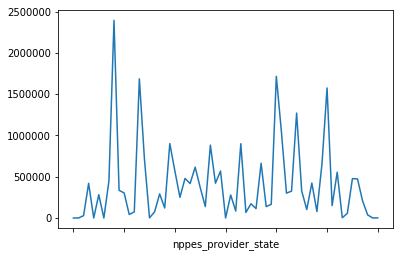

In [15]:
state_count['npi'].plot.line()

Even though New York City is within NY, **CA** beat NY in having the most prescriptions. That means for the state of NY, most of its claims for this Medicare program are highly concentrated in NYC.

Another look at prescriptions per state:

In [16]:
Prescriber_2017[['nppes_provider_state','npi']].groupby('nppes_provider_state').describe().head()

npi                                            \
                         count          mean           std           min   
nppes_provider_state                                                       
AA                        40.0  1.508161e+09  2.918620e+08  1.023447e+09   
AE                       565.0  1.409913e+09  2.799656e+08  1.003016e+09   
AK                     27588.0  1.502100e+09  2.866308e+08  1.003062e+09   
AL                    420010.0  1.499610e+09  2.867802e+08  1.003008e+09   
AP                       319.0  1.551151e+09  2.073183e+08  1.013085e+09   

                                                                              
                               25%           50%           75%           max  
nppes_provider_state                                                          
AA                    1.215473e+09  1.649646e+09  1.750510e+09  1.992932e+09  
AE                    1.164604e+09  1.336111e+09  1.720372e+09  1.972503e+09  
AK                    1.245278e+09  1.518094e+09  1.750359e+09  1.992902e+09  
AL                    1.245620e+09  1.497799e+09  1.750348e+09  1.992997e+09  
AP                    1.457502e+09  1.457502e+09  1.679557e+09  1.992770e+09

Better visualization with most prescription count per state **(CA)** at top.

In [17]:
Prescriber_2017[['nppes_provider_state','npi']].groupby('nppes_provider_state').count().sort_values("npi")
Distinct_State = Prescriber_2017.nppes_provider_state.unique()
Prescription = []

for state in Distinct_State:
    state_prescription =  len(Prescriber_2017[Prescriber_2017["nppes_provider_state"] == state])    
    Prescription.append(state_prescription)

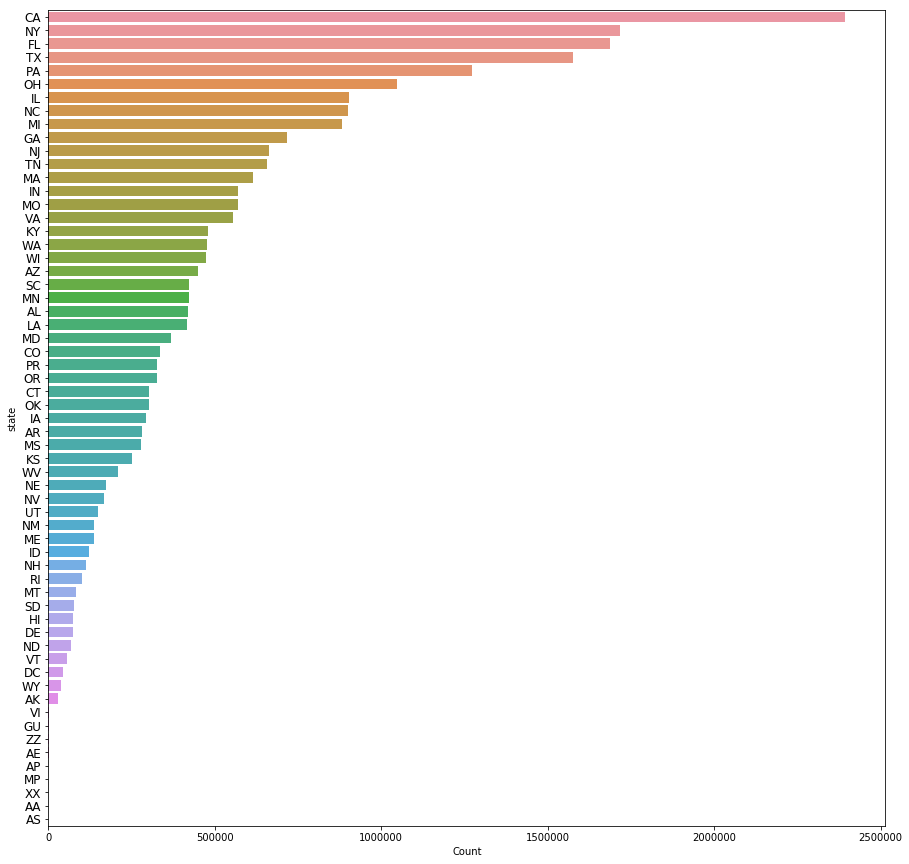

In [18]:
df = pd.DataFrame(
    {'state': Distinct_State,
     'Count' : Prescription
     })

df = df.sort_values("Count", ascending=False).reset_index(drop=True)

f, ax = plt.subplots(figsize=(15, 15)) 
ax.set_yticklabels(df.state, rotation='horizontal', fontsize='large')
g = sns.barplot(y = df.state, x= df.Count)
plt.show()

There are some entries at the bottom that are blank since these states do not exist (VI, GU, ZZ, AE, AP, MP, XX, AA, AS). These were obviously tranposing errors.

Even though this is the case, CA is clearly at the top with most prescriptions written.

## Median and Variance: 
### Now, let us look at continuous variable data across different columns. We can look at central locations and spread of data with boxplots.

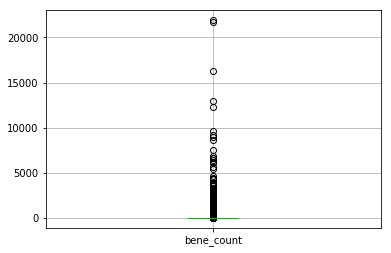

In [19]:
Prescriber_2017.boxplot(column = 'bene_count')

Some drugs are more popular than others, but a majority of beneficiaries per drug are in the **under 5000 range**.

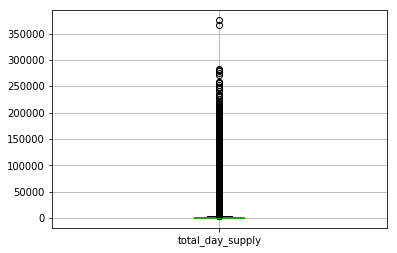

In [20]:
Prescriber_2017.boxplot(column = 'total_day_supply')

There is a huge range for drug amount per day.

In [21]:
Prescriber_2017.sort_values(by='total_drug_cost', ascending=False) # Dataframe sorted by total_drug_cost with the highest amount at the top.

,npi,nppes_provider_last_org_name,nppes_provider_first_name,nppes_provider_city,nppes_provider_state,specialty_description,description_flag,drug_name,generic_name,bene_count,...,total_30_day_fill_count,total_day_supply,total_drug_cost,bene_count_ge65,bene_count_ge65_suppress_flag,total_claim_count_ge65,ge65_suppress_flag,total_30_day_fill_count_ge65,total_day_supply_ge65,total_drug_cost_ge65
9035970,1366754715,HINOJOSA,KIM,SAN ANTONIO,TX,Nurse Practitioner,S,HARVONI,LEDIPASVIR/SOFOSBUVIR,175.0,...,451.0,12628,13881533.32,77.0,NaN,213.0,NaN,213.0,5964.0,6547734.84
7489288,1184779415,FEYSSA,EYOB,PHILADELPHIA,PA,Internal Medicine,S,HARVONI,LEDIPASVIR/SOFOSBUVIR,118.0,...,317.0,8876,10210189.58,72.0,NaN,197.0,NaN,197.0,5516.0,6345185.48
12699562,1366477044,WHITE,RICHARD,ROCHESTER,NY,Pulmonary Disease,S,LETAIRIS,AMBRISENTAN,106.0,...,1071.0,32070,9828742.44,68.0,NaN,674.0,NaN,678.0,20310.0,6184612.87
17009502,1144267766,ANDERSON,LARRY,SEATTLE,WA,Medical Oncology,S,REVLIMID,LENALIDOMIDE,86.0,...,737.0,20379,9319303.75,NaN,#,650.0,NaN,650.0,17971.0,8166394.43
6812142,1417912783,BAUGHMAN,ROBERT,CINCINNATI,OH,Pulmonary Disease,S,H.P. ACTHAR,CORTICOTROPIN,23.0,...,185.1,4632,8324385.88,NaN,*,55.0,NaN,55.2,1088.0,2319411.64
11900777,1245371814,CREIGHTON,WILLIAM,BRAWLEY,CA,Allergy/ Immunology,S,FIRAZYR,ICATIBANT ACETATE,NaN,...,129.0,258,8103040.92,0.0,NaN,0.0,NaN,0.0,0.0,0.00
22746701,1295888030,PICONE,MARY ANN,TEANECK,NJ,Neurology,S,COPAXONE,GLATIRAMER ACETATE,119.0,...,1225.3,35417,7737954.53,56.0,NaN,477.0,NaN,604.4,17517.0,3820476.69
9679600,1558369553,MANDEL,DAVID,MAYFIELD VILLAGE,OH,Rheumatology,S,H.P. ACTHAR,CORTICOTROPIN,15.0,...,129.8,3256,7368859.79,NaN,*,76.0,NaN,82.6,2052.0,4067003.47
4151166,1174610018,HERRAKA,IHAB,BROOKSVILLE,FL,Gastroenterology,S,SOVALDI,SOFOSBUVIR,73.0,...,255.0,7140,7295212.24,19.0,NaN,64.0,NaN,64.0,1792.0,1830422.20
23915961,1205912268,MCLAUGHLIN,VALLERIE,ANN ARBOR,MI,Cardiology,S,OPSUMIT,MACITENTAN,90.0,...,823.0,24675,7058641.51,57.0,NaN,525.0,NaN,525.0,15750.0,4503704.79


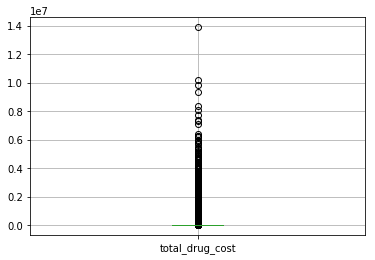

In [22]:
Prescriber_2017.boxplot(column = 'total_drug_cost')

Based on the Cost axis, there must be huge variance between minimum value and maximum value of this particular column. Will verify with descriptive statistics.

In [23]:
Prescriber_2017['total_drug_cost'].describe()

count    2.520913e+07
mean     4.606025e+03
std      2.917278e+04
min      0.000000e+00
25%      2.439000e+02
50%      6.432600e+02
75%      2.175990e+03
max      1.388153e+07
Name: total_drug_cost, dtype: float64

Here, we can see that the minimum value is 0 dollars and the maximum value is close to 14 million dollars. The range is huge and the reason for the cost axis scaled as it is. 

Now that we have an idea of the size and shape of the data, we can start answering our prompt. 

## Provider Density

Let us start off with getting some summary statistics for each provider per state.

In [24]:
#Need to change data type from int to str so that math is not computed on npi ID numbers.
Prescriber_2017['npi'] = Prescriber_2017['npi'].apply(str)

In [25]:
Prescriber_2017[["nppes_provider_state","npi"]].groupby('nppes_provider_state').describe().head(20)

npi                        
                        count unique         top freq
nppes_provider_state                                 
AA                         40     14  1750510327   16
AE                        565     56  1780051482   79
AK                      27588   1662  1598757312  174
AL                     420010  12016  1386656619  390
AP                        319     38  1457502114  116
AR                     282027   7653  1376523316  350
AS                          6      3  1750634473    3
AZ                     449232  18060  1992783492  277
CA                    2394317  93657  1720134695  433
CO                     335114  15582  1013936764  316
CT                     303819  13378  1316085665  382
DC                      42771   2984  1467401182  242
DE                      73883   2839  1407811490  284
FL                    1686023  56325  1588658348  515
GA                     715593  23498  1285761833  572
GU                       1762    121  1891844635   85
HI                      74683   3331  1669425906  300
IA                     291920   9036  1396724167  350
ID                     121279   4467  1558300491  266
IL                     901698  36010  1184687717  416

Each state is in alphabeltical order. And for each state, the total count of prescriptions is given, the number of different providers are given, and the provider that showed up the most in each state. This is a great preview to how these numbers are represented as a visualization.

In order to get at provider density per state, we will target **npi unique column per state** numbers.

The following two blocks of code were run before, but main differences here are that the data type for npi changed from int to str and that the targeted column is used as the count values per state.

In [26]:
Prescriber_2017[['nppes_provider_state','npi']].groupby('nppes_provider_state').count().sort_values("npi")
Distinct_State = Prescriber_2017.nppes_provider_state.unique()
Prescription = []

for state in Distinct_State:
    st = Prescriber_2017[Prescriber_2017["nppes_provider_state"] == state]
    npi_unique = st.npi.unique()
    state_prescription =  len(npi_unique)    
    Prescription.append(state_prescription)

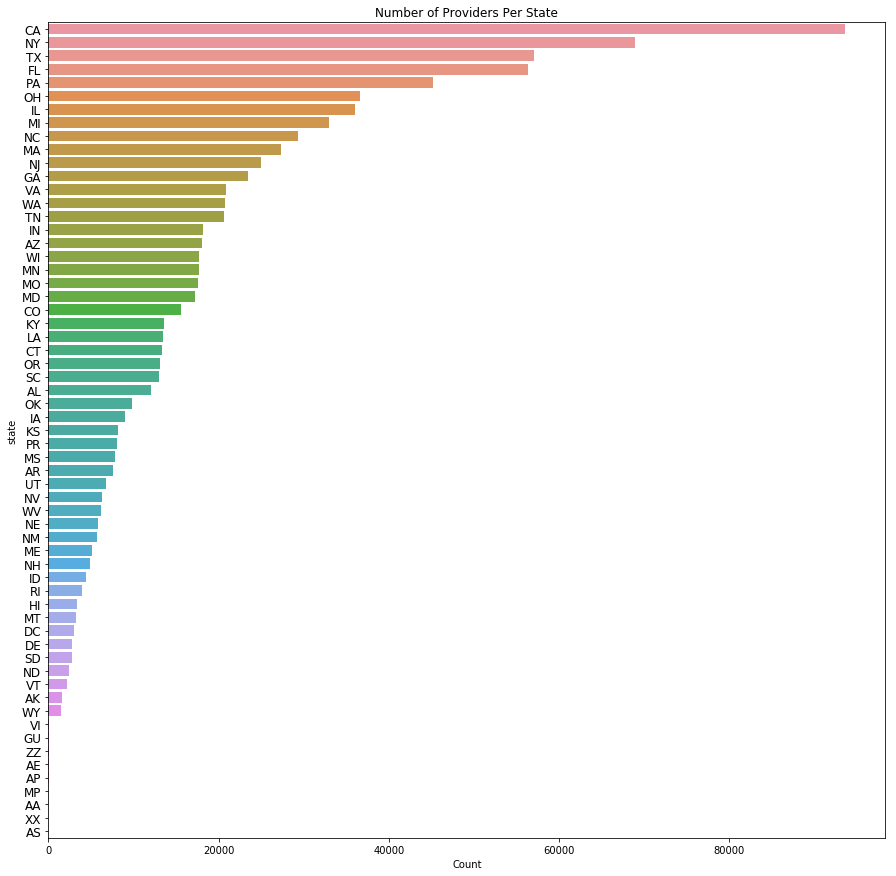

In [27]:
df = pd.DataFrame(
    {'state': Distinct_State,
     'Count' : Prescription
     })

df = df.sort_values("Count", ascending=False).reset_index(drop=True)

f, ax = plt.subplots(figsize=(15, 15)) 
ax.set_yticklabels(df.state, rotation='horizontal', fontsize='large')
g = sns.barplot(y = df.state, x= df.Count).set_title("Number of Providers Per State")
plt.show()

As we can see here towards the end of this plot, there are state abreviations that do not exist in real life. These will be deleted since they are not relevant for the intended analysis.

In [28]:
Prescriber_2017_edited = Prescriber_2017.loc[~Prescriber_2017['nppes_provider_state'].isin(['VI', 'GU','ZZ', 'AE', 'AP', 'MP', 'AA', 'XX', 'AS'])]

In [29]:
Prescriber_2017_edited[['nppes_provider_state','npi']].groupby('nppes_provider_state').count().sort_values("npi")
Distinct_State = Prescriber_2017_edited.nppes_provider_state.unique()
Prescription = []

for state in Distinct_State:
    st = Prescriber_2017_edited[Prescriber_2017_edited["nppes_provider_state"] == state]
    npi_unique = st.npi.unique()
    state_prescription =  len(npi_unique)    
    Prescription.append(state_prescription)

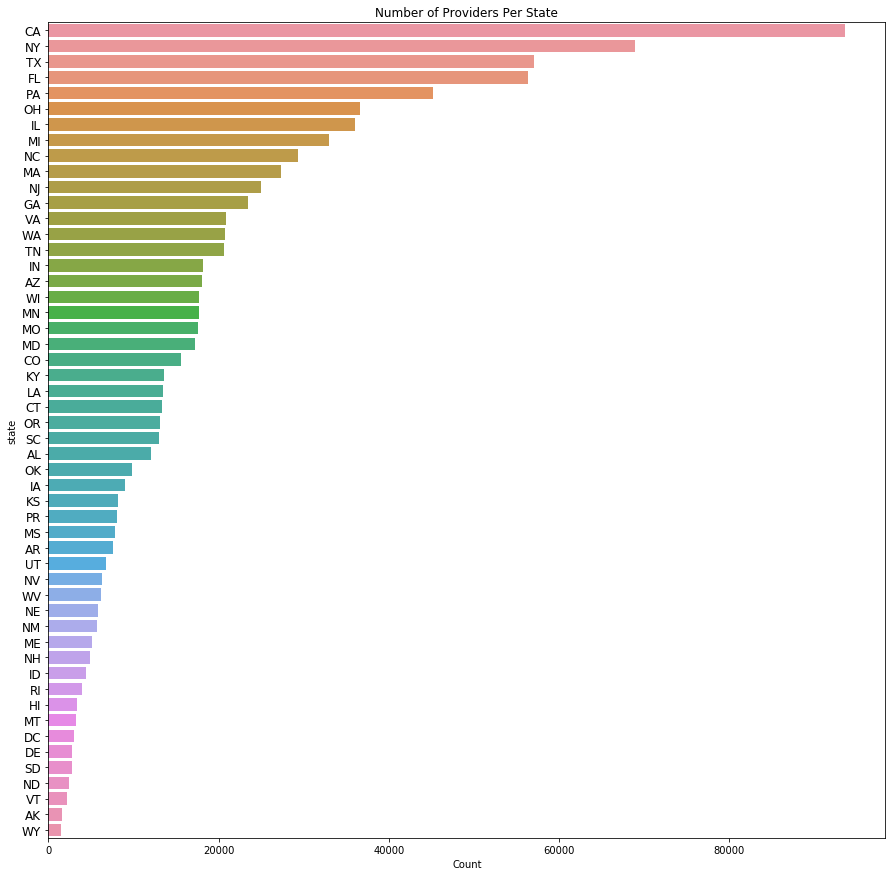

In [30]:
df = pd.DataFrame(
    {'state': Distinct_State,
     'Count' : Prescription
     })

df = df.sort_values("Count", ascending=False).reset_index(drop=True)

f, ax = plt.subplots(figsize=(15, 15)) 
ax.set_yticklabels(df.state, rotation='horizontal', fontsize='large')
g = sns.barplot(y = df.state, x= df.Count).set_title("Number of Providers Per State")
plt.show()

Great! All the non-sense states are eliminated to clean up the data. Let us make sure how much data was taken out when comparing the original dataset of 25209130 prescriptions.

In [31]:
len(Prescriber_2017_edited)

25201148

In [32]:
25209130-25201148

7982

In [33]:
(7982/25209130)*100

0.031663131571775784

Only .03% of the whole dataset was eliminated. This is negligible.

To take this visualization further, we can look at providers on a US map. 

In [34]:
data = dict(type = 'choropleth',
           locations = df['state'],
           locationmode = 'USA-states',
           colorscale = 'Cividis',
            text = df['state'],
            marker = dict (line = dict(color = 'rgb(255,255,255)',width=2)),
           z = df['Count'],
           colorbar = {'title':'No. of Providers'})

layout = dict(title = '2017 Provider Count by State (Hover for Breakdown)',
         geo=dict(scope = 'usa',showlakes = True,lakecolor='rgb(255,255,255)')) 

choromap2 = go.Figure(data = [data],layout=layout)
iplot(choromap2)

Gradients of color represent volume of each provider per state. Moving cursor over a state will give you the exact number of provider counts along with the two-letter state abbreviation.

We can see that the brightest states have the highest amount of providers listed in this special Medicare plan. The darker states have the least amount of providers. This follows the prior bar chart. Let us do the same descriptive statistics, bar chart and US map breakdown for the remaining two variables- provider specialties and drug costs.

## Provider Specialties

In [35]:
Prescriber_2017_edited[["nppes_provider_state","specialty_description"]].groupby('nppes_provider_state').describe().head(10)

specialty_description                                  
                                     count unique                top    freq
nppes_provider_state                                                        
AK                                   27588     59    Family Practice    9483
AL                                  420010     87    Family Practice  129309
AR                                  282027     84    Family Practice  117865
AZ                                  449232     97    Family Practice  114785
CA                                 2394317    130  Internal Medicine  743892
CO                                  335114     91    Family Practice  110933
CT                                  303819     91  Internal Medicine  112568
DC                                   42771     76  Internal Medicine   15213
DE                                   73883     68    Family Practice   22140
FL                                 1686023    119  Internal Medicine  501328

This is just like the prior summary statistics breakdown for providers, but the difference here is that provider specialties are grouped by state. Numbers to target from this table are from the **speciality_description unique** numbers per state.

In [36]:
Prescriber_2017_edited[['nppes_provider_state','specialty_description']].groupby('nppes_provider_state').count().sort_values("specialty_description")
Distinct_State = Prescriber_2017_edited.nppes_provider_state.unique()
Prescription = []

for state in Distinct_State:
    st = Prescriber_2017_edited[Prescriber_2017_edited["nppes_provider_state"] == state]
    specialty_unique = st.specialty_description.unique()
    state_specialties =  len(specialty_unique)    
    Prescription.append(state_specialties)

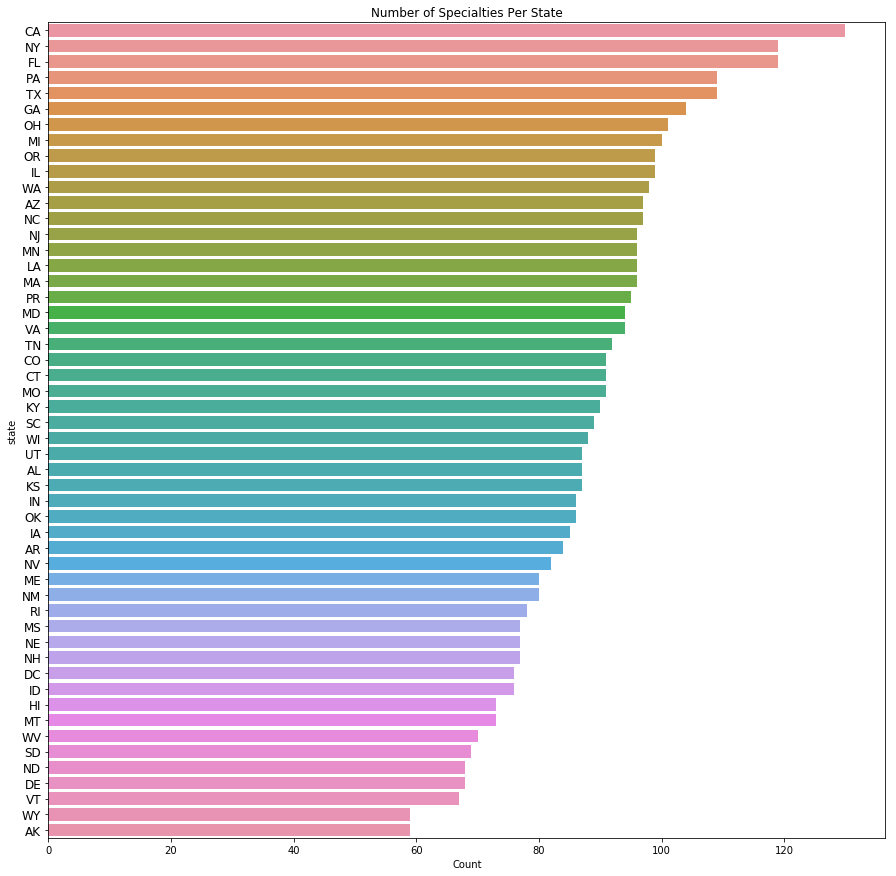

In [37]:
df = pd.DataFrame(
    {'state': Distinct_State,
     'Count' : Prescription
      })

df = df.sort_values("Count", ascending=False).reset_index(drop=True)

f, ax = plt.subplots(figsize=(15, 15)) 
ax.set_yticklabels(df.state, rotation='horizontal', fontsize='large')
g = sns.barplot(y = df.state, x= df.Count).set_title("Number of Specialties Per State")
plt.show()

In [38]:
data = dict(type = 'choropleth',
           locations = df['state'],
           locationmode = 'USA-states',
           colorscale = [
    [0.0, 'rgb(242,240,247)'],
    [0.2, 'rgb(218,218,235)'],
    [0.4, 'rgb(188,189,220)'],
    [0.6, 'rgb(158,154,200)'],
    [0.8, 'rgb(117,107,177)'],
    [1.0, 'rgb(84,39,143)']
    ],
            text = df['state'],
            marker = dict (line = dict(color = 'rgb(255,255,255)',width=2)),
           z = df['Count'],
           colorbar = {'title':'No. of Specialties'})

layout = dict(title = '2017 Specialty Count by State (Hover for Breakdown)',
         geo=dict(scope = 'usa',showlakes = True,lakecolor='rgb(240, 240, 240)')) 

choromap2 = go.Figure(data = [data],layout=layout)
iplot(choromap2)

The same visualization effects are repeated here. It is just that the color differences between states are not as extreme as was the case with provider density since variance was not huge between states when it come to number of different specialities. This is why most of the states are of the same shade. This parallels the bar chart which had similar bar lengths across majority of the listed states. However, CA still at the top of the list of number of specialities per state.

Now for the last variable to compare across US states - drug costs.

## Drug Costs

Descriptive Statistics for drug costs grouped by state.

In [39]:
Prescriber_2017_edited[["nppes_provider_state","total_drug_cost"]].groupby('nppes_provider_state').describe().head(10)

total_drug_cost                                   \
                               count         mean           std   min   
nppes_provider_state                                                    
AK                           27588.0  2979.923972  16391.820532  8.69   
AL                          420010.0  5166.838443  33747.507952  0.00   
AR                          282027.0  3901.293584  29231.948595  4.80   
AZ                          449232.0  4440.722735  31934.085594  0.11   
CA                         2394317.0  4949.535077  31402.724589  0.00   
CO                          335114.0  3899.274565  27313.913705  0.00   
CT                          303819.0  5197.018114  27092.517591  0.00   
DC                           42771.0  5905.983863  37023.658639  8.98   
DE                           73883.0  5126.006555  27079.420278  0.00   
FL                         1686023.0  5008.470346  31361.079148  0.00   

                                                                
                           25%      50%        75%         max  
nppes_provider_state                                            
AK                    175.4425  408.410  1195.0075   628142.30  
AL                    266.0800  728.615  2552.5900  5927532.13  
AR                    219.8000  572.660  1873.4550  4435317.54  
AZ                    234.8875  600.705  1910.1925  5697183.46  
CA                    248.3300  647.000  2150.1000  8103040.92  
CO                    222.5600  551.240  1684.6825  3281051.05  
CT                    264.3200  734.220  2749.5400  3426139.94  
DC                    203.0350  517.930  1888.1600  3023211.85  
DE                    253.7150  662.620  2257.6450  1613789.04  
FL                    256.1100  679.390  2268.0100  7295212.24

There is a huge range in drug costs per state and across states. Drug costs are not discrete values like the variables that we just handled. Instead, it is a continuous variable. Therefore, in order to get a representative drug cost per state to compare drug costs across the US, average drug costs will be used. So the numbers to target from this table are from the **total_drug_cost mean** column.

In [40]:
Prescriber_2017_edited[['nppes_provider_state','total_drug_cost']].groupby('nppes_provider_state').count().sort_values("total_drug_cost")
Distinct_State = Prescriber_2017_edited.nppes_provider_state.unique()
Prescription = []

for state in Distinct_State:
    st = Prescriber_2017_edited[Prescriber_2017_edited["nppes_provider_state"] == state]
    mean_drug_cost = st.total_drug_cost.mean()    
    Prescription.append(mean_drug_cost)

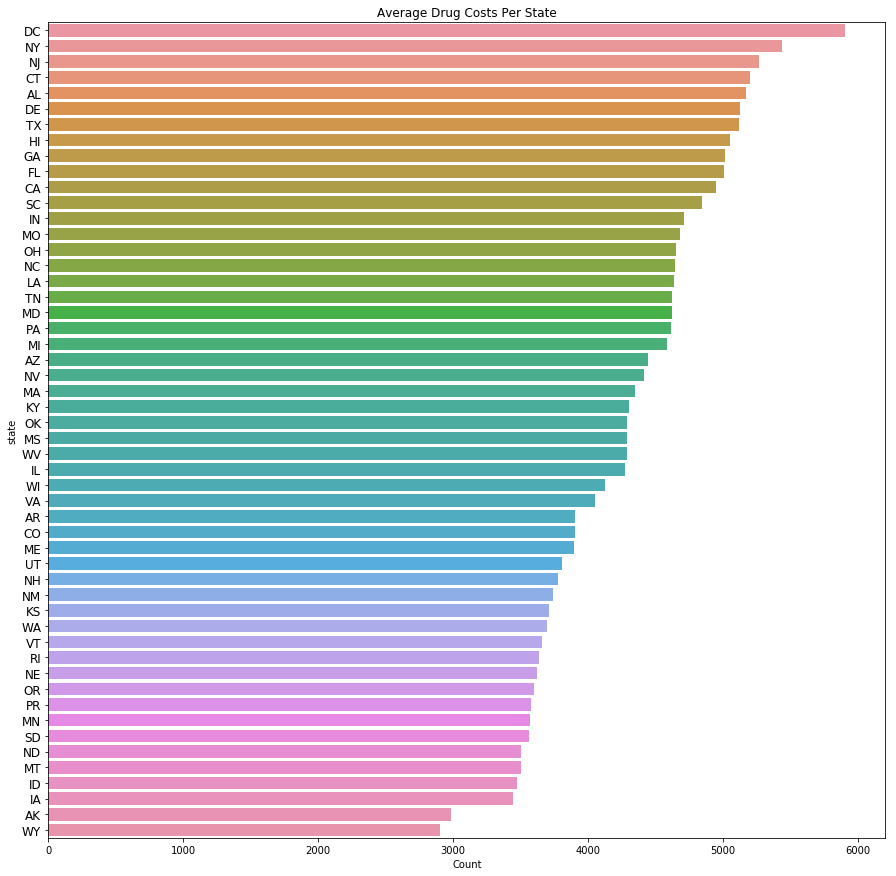

In [41]:
df = pd.DataFrame(
    {'state': Distinct_State,
     'Count' : Prescription
      })

df = df.sort_values("Count", ascending=False).reset_index(drop=True)

f, ax = plt.subplots(figsize=(15, 15)) 
ax.set_yticklabels(df.state, rotation='horizontal', fontsize='large')
g = sns.barplot(y = df.state, x= df.Count).set_title("Average Drug Costs Per State")
plt.show()

CA is not at the top this time. Instead, the top average drug costs are coming from East Coast regions - **DC, NY, NJ**.

In [42]:
data = dict(type = 'choropleth',
           locations = df['state'],
           locationmode = 'USA-states',
           colorscale = 'Greens',
            text = df['state'],
            marker = dict (line = dict(color = 'rgb(270,270,270)',width=2)),
           z = df['Count'],
           colorbar = {'title':'Av. Drug Cost'})

layout = dict(title = '2017 Average Drug Cost by State (Hover for Breakdown)',
         geo=dict(scope = 'usa',showlakes = True,lakecolor='rgb(230, 230, 230)')) 

choromap2 = go.Figure(data = [data],layout=layout)
iplot(choromap2)

The lighest states have the highest average drug costs. These are mainly on the East Cost and Southeast region of the US.

Given that drug costs are continuous variable, good to have boxplots to see the median and spread of drug costs within each state and across states.

### Boxplots of Total Drug Costs Across States

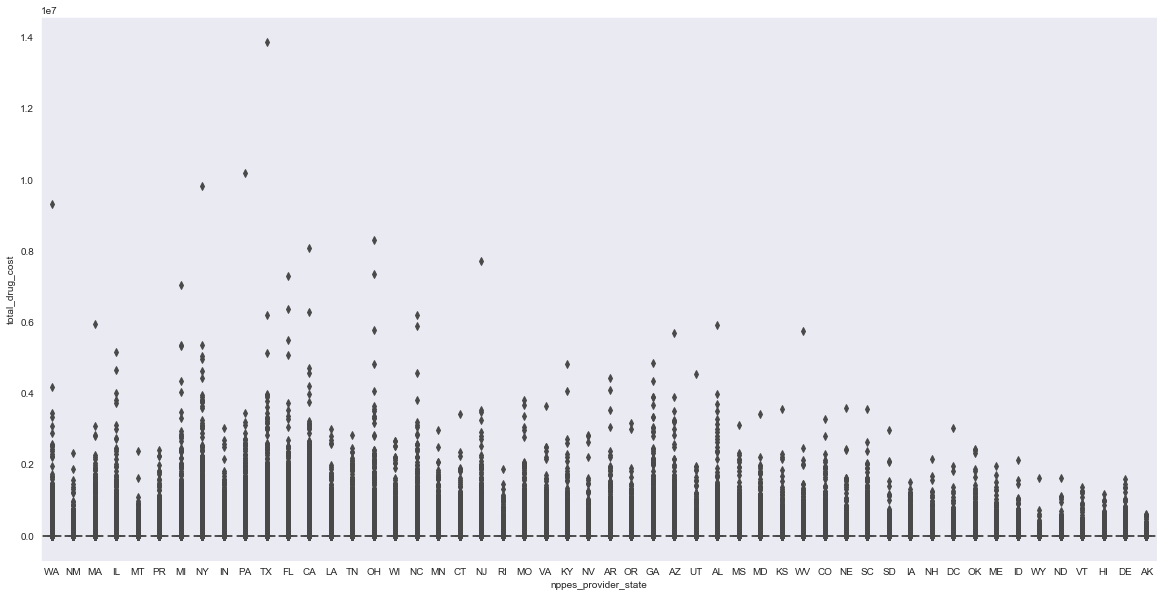

In [43]:
plt.figure(figsize=(20, 10))
sns.set_style("dark")
sns.boxplot(x="nppes_provider_state", y="total_drug_cost", data=Prescriber_2017_edited, palette="deep")

From here, we can see the top 3 states with the largest variance in total drug cost are: **TX > PA > NY**.

# Conclusion:

## Based on the analysis, what is correlated with geography is:
- Provider Density was correlated with populous states: CA > NY > TX > FL > PA. **NY beat out TX and FL** even though it is smaller in square footage than TX and FL. One thing to remember is that provider density is based on those who are using Medicare Part D.
- Provider Specialties was correlated with populous states as well: CA > NY > FL > TX > PA. This time around **FL had more specialties than TX**. Another thing to mention is the shape of the distribution was more uniform. CA still outnumbered the rest of the states, but the majority of states shared similar amount of different specialties.

One thing to remember is that provider density and provider speciality data is based on those who are using Medicare Part D. So these observations do not represent all healthcare providers across the US.

- Total Drug Cost had a completely different trend than in other data attributes: DC > NY > NJ > CT > AL. It seems like these states, which are concentrated in **Northeast portion** of America have the least subsidies for drugs. Then again, based on the caveats mentioned in the beginning of this analysis, total cost of drugs is uncertain since Medicare Part D is only a portion of the drug process.